# Implementing MLP with Pytorch

## Simple image classifier using nn.Sequential

* Loading the necessary libraries and their helper functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD, Adam, AdamW
from tqdm import tqdm
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

* Setting up device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

* This code downloads the dataset to the created FashionMnist directory, dataset consists of 60000 images in train set and 10000 images in the test set along with their corresponding labels

In [3]:
train_dataset = torchvision.datasets.FashionMNIST('./FashionMnist',train=True, download=False, transform=None)
test_dataset = torchvision.datasets.FashionMNIST('./FashionMnist',train=False, download=False, transform=None)

* Data splitting and preparation

In [4]:
X_train_full, y_train_full = train_dataset.train_data, train_dataset.train_labels
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [5]:
X_test, y_test = test_dataset.test_data, test_dataset.test_labels

* Moving all tensors to gpu

In [6]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_valid, y_valid = X_valid.to(device), y_valid.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Dtype of X_train: {X_train.dtype}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: torch.Size([55000, 28, 28]), y_train shape: torch.Size([55000])
Dtype of X_train: torch.uint8
X_test shape: torch.Size([10000, 28, 28]), y_test shape: torch.Size([10000])


* Scaling pixel intensities to 0-1 range by dividing by 255

In [7]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

* Labels of train set

In [ ]:
y_train

tensor([9, 0, 0,  ..., 9, 0, 2], device='cuda:0')

* Class names corresponding to labels

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

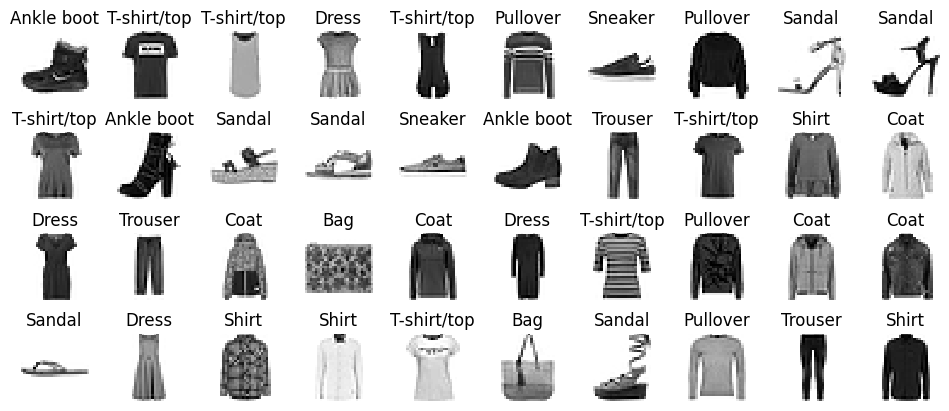

In [ ]:
# Plotting sample of training data
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train.cpu()[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train.cpu()[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

* Creating model using nn.Sequential

In [12]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.model = nn.Sequential(OrderedDict([
            ('Flatten', nn.Flatten()),
            ('Dense1', nn.Linear(in_features=784,out_features=300)),
            ('relu1', nn.ReLU()),
            ('dense2', nn.Linear(in_features=300, out_features=100)),
            ('relu2', nn.ReLU()),
            ('Out_layer', nn.Linear(in_features=100, out_features=10))
        ]))

    def forward(self, input):
        return self.model(input)


* Model summary can be visualized

In [42]:
classifier = MyModel().to(device) # moving model to gpu
classifier

MyModel(
  (model): Sequential(
    (Flatten): Flatten(start_dim=1, end_dim=-1)
    (Dense1): Linear(in_features=784, out_features=300, bias=True)
    (relu1): ReLU()
    (dense2): Linear(in_features=300, out_features=100, bias=True)
    (relu2): ReLU()
    (Out_layer): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [11]:
print(f"Dense1 shape -> weight:{classifier.model.Dense1.weight.shape}, bias:{classifier.model.Dense1.bias.shape}")

Dense1 shape -> weight:torch.Size([300, 784]), bias:torch.Size([300])


### Training the model

* Creating train, val and test datasets using TensorDataset

In [31]:
train_set = DataLoader(TensorDataset(X_train, y_train), batch_size=25)
val_set = DataLoader(TensorDataset(X_valid, y_valid))
test_set = DataLoader(TensorDataset(X_test, y_test))

* Defining loss and optimizer

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(classifier.parameters(), lr=0.05)

* Setting the tensors to gpu and creating y_train_enc which is one hot encoded for training the multiclass claffifier

In [44]:
n_epochs = 10
loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(n_epochs):
    total_loss = []
    classifier.train()
    for inputs, labels in tqdm(train_set):
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        total_loss.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(sum(total_loss)/(55000/5))

    classifier.eval()
    with torch.inference_mode():
        train_acc = torch.sum(classifier(X_train).argmax(dim=1) == y_train) / 55000
        val_acc = torch.sum(classifier(X_valid).argmax(dim=1) == y_valid) / 5000

        train_acc_list.append(train_acc.item())
        val_acc_list.append(val_acc.item())

        print(f"Epoch: {epoch+1}, loss: {sum(total_loss)/55000}, train_acc: {train_acc}, val_acc: {val_acc}")


100%|██████████| 2200/2200 [00:07<00:00, 292.35it/s]


Epoch: 1, loss: 0.025670873001217842, train_acc: 0.845690906047821, val_acc: 0.843999981880188


100%|██████████| 2200/2200 [00:07<00:00, 295.58it/s]


Epoch: 2, loss: 0.01691288873553276, train_acc: 0.8646363615989685, val_acc: 0.8561999797821045


100%|██████████| 2200/2200 [00:07<00:00, 293.70it/s]


Epoch: 3, loss: 0.015011187642812729, train_acc: 0.8728363513946533, val_acc: 0.861799955368042


100%|██████████| 2200/2200 [00:06<00:00, 351.66it/s]


Epoch: 4, loss: 0.013800712302327156, train_acc: 0.8797454237937927, val_acc: 0.8639999628067017


100%|██████████| 2200/2200 [00:05<00:00, 412.18it/s]


Epoch: 5, loss: 0.012909827753901482, train_acc: 0.8847817778587341, val_acc: 0.8637999892234802


100%|██████████| 2200/2200 [00:05<00:00, 407.57it/s]


Epoch: 6, loss: 0.012181238271296024, train_acc: 0.8884544968605042, val_acc: 0.8667999505996704


100%|██████████| 2200/2200 [00:05<00:00, 384.98it/s]


Epoch: 7, loss: 0.011557130143046379, train_acc: 0.8935090899467468, val_acc: 0.8700000047683716


100%|██████████| 2200/2200 [00:05<00:00, 418.31it/s]


Epoch: 8, loss: 0.01100589707493782, train_acc: 0.8944181799888611, val_acc: 0.8709999918937683


100%|██████████| 2200/2200 [00:06<00:00, 343.49it/s]


Epoch: 9, loss: 0.010517606511712074, train_acc: 0.90138179063797, val_acc: 0.8736000061035156


100%|██████████| 2200/2200 [00:07<00:00, 300.98it/s]


Epoch: 10, loss: 0.010074243880808353, train_acc: 0.9009636044502258, val_acc: 0.8707999587059021


In [45]:
classifier.eval()
with torch.inference_mode():
        test_acc = torch.sum(classifier(X_test).argmax(dim=1) == y_test) / 10000
        print(f"test_acc: {test_acc}")

test_acc: 0.8682000041007996


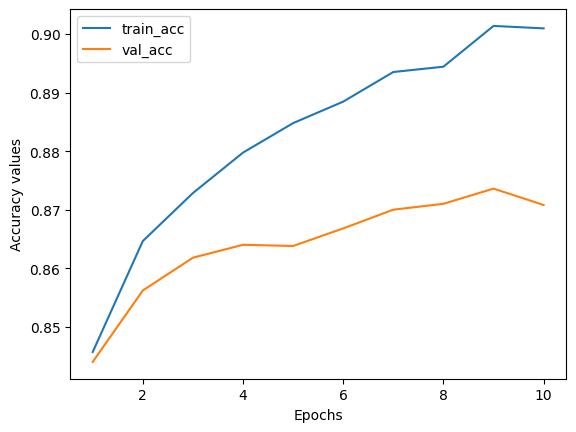

In [46]:
xl = np.arange(1,n_epochs+1)

plt.xlabel('Epochs')
plt.ylabel('Accuracy values')
plt.plot(xl, train_acc_list, label='train_acc')
plt.plot(xl, val_acc_list, label='val_acc')
plt.legend()
plt.show()

* Achieved 83% accuracy on test set

## Regression MLP using nn.Sequential

In [61]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()

X_ch , y_ch = data.data, data.target
X_ch.shape, y_ch.shape

((20640, 8), (20640,))

* Normalizing X_ch[:, 1], 2nd column

In [62]:
X_ch_1_mean = np.mean(X_ch[:, 1])
X_ch_1_std = np.std(X_ch[:, 1])
X_ch[:, 1] = (X_ch[:, 1] - X_ch_1_mean)/(X_ch_1_std)

* Splitting the data into train, val, test

In [63]:
from sklearn.model_selection import train_test_split

X_train_ch, X_test_ch, y_train_ch, y_test_ch = train_test_split(X_ch, y_ch, random_state=42)
X_train_ch, X_valid_ch, y_train_ch, y_valid_ch = train_test_split(X_train_ch, y_train_ch, random_state=42)

In [64]:
print(f"X_train: {X_train_ch.shape}, y_train: {y_train_ch.shape}")
print(f"X_valid: {X_valid_ch.shape}, y_valid: {y_valid_ch.shape}")
print(f"X_test: {X_test_ch.shape}, y_test: {y_test_ch.shape}")

X_train: (11610, 8), y_train: (11610,)
X_valid: (3870, 8), y_valid: (3870,)
X_test: (5160, 8), y_test: (5160,)


* Moving all data to gpu

In [65]:
X_train_ch,y_train_ch = torch.tensor(X_train_ch).float().to(device),torch.tensor(y_train_ch).float().to(device)
X_valid_ch,y_valid_ch = torch.tensor(X_valid_ch).float().to(device),torch.tensor(y_valid_ch).float().to(device)
X_test_ch,y_test_ch = torch.tensor(X_test_ch).float().to(device),torch.tensor(y_test_ch).float().to(device)

* Creating dataloader for training

In [66]:
batch_size = 1
train_dataloader = DataLoader(TensorDataset(X_train_ch,y_train_ch), batch_size=batch_size)

* Basic regression model

In [67]:
class My_Reg_model(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.model(x)

In [68]:
regressor = My_Reg_model(8).to(device)

In [69]:
criterion = nn.MSELoss()
optimizer = Adam(regressor.parameters(), lr=1e-3)

* Using R2 score for evaluation

In [70]:
from torchmetrics.regression import R2Score
r2 = R2Score().to(device)

* Training Script

In [71]:
loss_list = []

In [72]:
n_epochs = 10

for epoch in range(n_epochs):
    total_loss = []
    regressor.train()
    for inputs, labels in tqdm(train_dataloader):
        outputs = regressor(inputs)
        loss = criterion(outputs, labels)
        total_loss.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = sum(total_loss)/(len(X_train_ch)/batch_size)
    loss_list.append(avg_loss)

    regressor.eval()
    with torch.inference_mode():
        train_preds = regressor(X_train_ch)
        train_preds = train_preds.reshape(train_preds.size(0))
        train_r2 = r2(train_preds, y_train_ch)

        val_preds = regressor(X_valid_ch)
        val_preds = val_preds.reshape(val_preds.size(0))
        val_r2 = r2(val_preds, y_valid_ch)

        print(f"Epoch: {epoch+1}, train r2: {train_r2}, validation r2: {val_r2}, Mse: {avg_loss}")

100%|██████████| 11610/11610 [00:41<00:00, 280.08it/s]


Epoch: 1, train r2: 0.34815651178359985, validation r2: 0.3405414819717407, Mse: 1.9712289571762085


100%|██████████| 11610/11610 [00:38<00:00, 301.60it/s]


Epoch: 2, train r2: 0.5220191478729248, validation r2: 0.5364576578140259, Mse: 0.8577324151992798


100%|██████████| 11610/11610 [00:38<00:00, 302.50it/s]


Epoch: 3, train r2: 0.5553454160690308, validation r2: 0.549522876739502, Mse: 0.6989018321037292


100%|██████████| 11610/11610 [00:38<00:00, 299.66it/s]


Epoch: 4, train r2: 0.5526202917098999, validation r2: 0.5670479536056519, Mse: 0.6551335453987122


100%|██████████| 11610/11610 [00:41<00:00, 281.85it/s]


Epoch: 5, train r2: 0.5698211789131165, validation r2: 0.5832791328430176, Mse: 0.6325409412384033


100%|██████████| 11610/11610 [00:38<00:00, 303.32it/s]


Epoch: 6, train r2: 0.5860129594802856, validation r2: 0.526414155960083, Mse: 0.6265347003936768


100%|██████████| 11610/11610 [00:38<00:00, 305.14it/s]


Epoch: 7, train r2: 0.5953357815742493, validation r2: 0.6113133430480957, Mse: 0.6135559678077698


100%|██████████| 11610/11610 [00:36<00:00, 316.71it/s]


Epoch: 8, train r2: 0.6012091636657715, validation r2: 0.6156718730926514, Mse: 0.6091572642326355


100%|██████████| 11610/11610 [00:24<00:00, 470.28it/s]


Epoch: 9, train r2: 0.5654309988021851, validation r2: 0.580901026725769, Mse: 0.5860937237739563


100%|██████████| 11610/11610 [00:24<00:00, 467.19it/s]


Epoch: 10, train r2: 0.6000864505767822, validation r2: 0.6155253052711487, Mse: 0.5888743996620178


In [73]:
regressor.eval()
with torch.inference_mode():
    test_preds = regressor(X_test_ch)
    test_preds = test_preds.reshape(test_preds.size(0))
    test_r2 = r2(test_preds, y_test_ch)
    print(f"Test r2: {test_r2}")

Test r2: 0.598178505897522


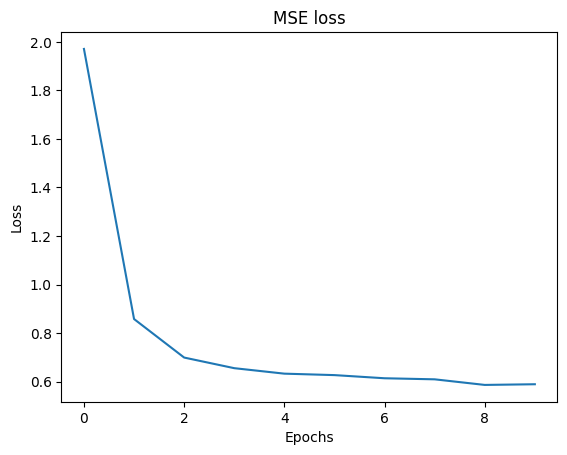

In [74]:
loss_list = [i.cpu().detach().numpy() for i in loss_list]
plt.title("MSE loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_list)